In [1]:
import ompy as om
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pymc3 as mc
import pandas as pd 
import fbu
from matplotlib import rc

dpi = 100
rc('figure',dpi = dpi)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

rc('font', size=14)
rc('legend', fontsize=14)
rc('text.latex')#, preamble=[r'\usepackage{siunitx}', r'\sisetup{detect-all}', r'\usepackage{lmodern}',r'\usepackage{amsmath}', r'\usepackage{sansmath}', r'\sansmath',r'\usepackage{mhchem}'])


<IPython.core.display.Javascript object>


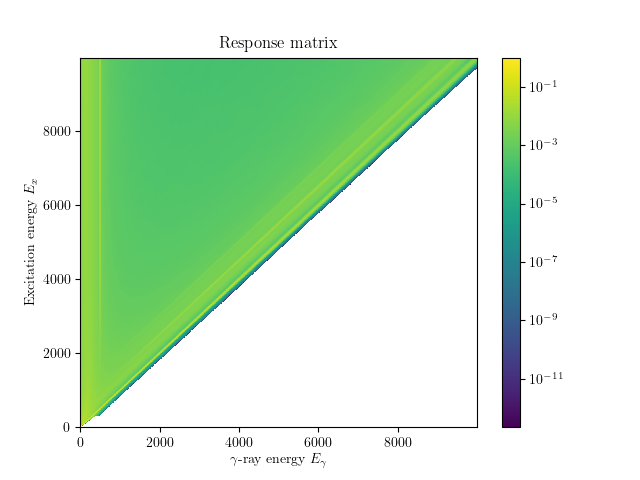

(<matplotlib.collections.QuadMesh at 0x7f47cd0ccef0>,
 <AxesSubplot:title={'center':'Response matrix'}, xlabel='$\\gamma$-ray energy $E_{\\gamma}$', ylabel='Excitation energy $E_{x}$'>,
 <Figure size 640x480 with 2 Axes>)

In [2]:
# Plot response matrix

%matplotlib notebook
%matplotlib notebook

# Synthetic true data before folding
raw_true = om.Matrix(path="Synthetic_data/threestates-cascades.m")

# Response matrix from file
folderpath = "ompy/OCL_response_functions/oscar2017_scale1.15"
response = om.Response(folderpath)
fwhm_abs = 30
Eg_true = raw_true.Eg

R_ompy_view, R_tab_view = response.interpolate(Eg_true, fwhm_abs=fwhm_abs, return_table=True)

R_ompy_view.plot(title="Response matrix", scale='log')

<IPython.core.display.Javascript object>


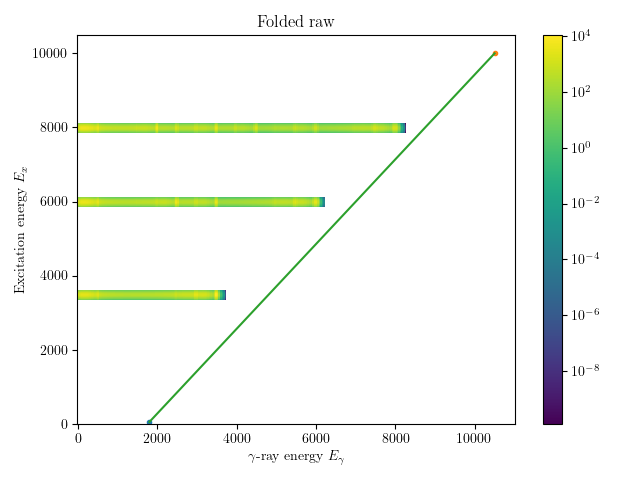

In [81]:
# Plot folded true data, mimicking detector output

%matplotlib notebook
%matplotlib notebook

# Fold raw with response
raw_true_folded = raw_true@R_ompy_view

Ex_true = raw_true_folded.Ex
gauss_fwhm = 100
# Apply a Gauss-smoothing to match the real detector resolution
raw_s = om.gauss_smoothing_matrix_1D(raw_true_folded, Ex_true, gauss_fwhm, axis = 'Ex')
raw_smooth = om.Matrix(values = raw_s, Ex = Ex_true, Eg = Eg_true)


# #Setting every count below this diagonal to zero
# raw_smooth.cut_diagonal(E1=(1800, 500), E2=(10500, 10000))

# Reduce number of bins
raw_smooth.rebin(axis = 'Eg', factor = 4)
raw_true.rebin(axis = 'Eg', factor = 4)

raw_smooth.plot()
plt.plot(1800,50, '.')
plt.plot(10500,10000, '.')
plt.plot([1800,10500],[50,10000])
plt.title('Folded raw')

plt.tight_layout()

<IPython.core.display.Javascript object>


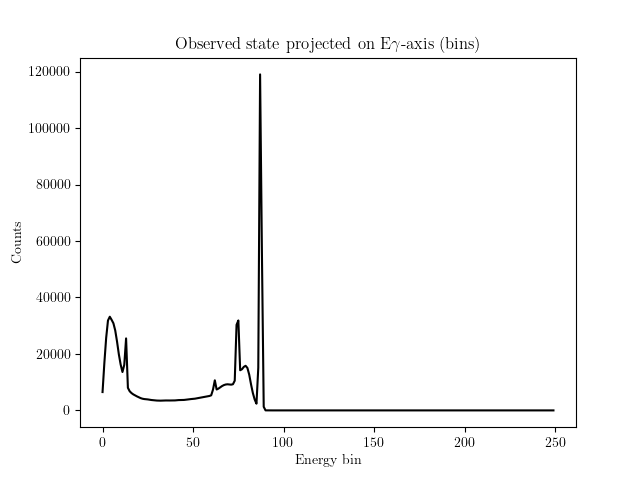

<IPython.core.display.Javascript object>


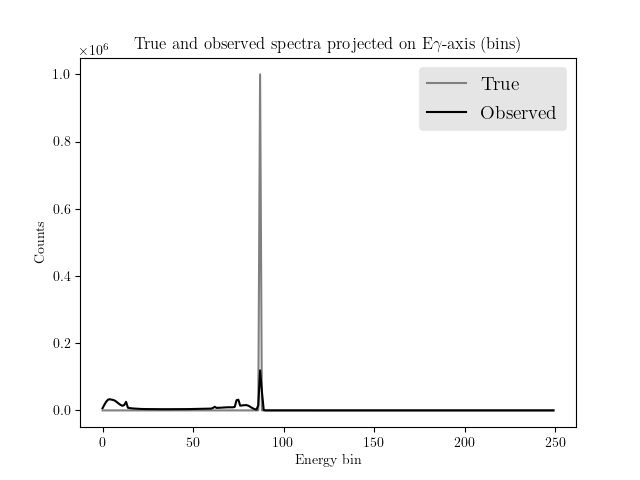

In [87]:
# Project raw
%matplotlib notebook
%matplotlib notebook

Eg = raw_smooth.Eg
# Define Ex axis bounds for projection
# Excited state: First / Second / Third 
# Emin           3200  /  5600  / 7600  
# Emax           4000  /  6400  / 8400  
Emin = 3200 
Emax = 4000    
# Project the true spectrum on the Eg axis
raw_true_projection, E_true = raw_true.projection(axis = 'Eg', Emin = Emin, Emax = Emax)

# Project state
raw_py, E = raw_smooth.projection(axis='Eg', Emin=Emin, Emax=Emax)

# Plot the projected observed spectrum
plt.plot(raw_py, color = 'black')
plt.title(r'Observed state projected on E$\gamma$-axis (bins)')
plt.xlabel("Energy bin")
plt.ylabel("Counts")

plt.figure()
# Compare true with observed
plt.plot(raw_true_projection, color = 'grey', label = 'True')
plt.plot(raw_py, color = 'black', label = 'Observed')
plt.title(r'True and observed spectra projected on E$\gamma$-axis (bins)')
plt.xlabel("Energy bin")
plt.ylabel("Counts")
plt.legend(facecolor='grey', framealpha=0.2)



plt.show()

<IPython.core.display.Javascript object>


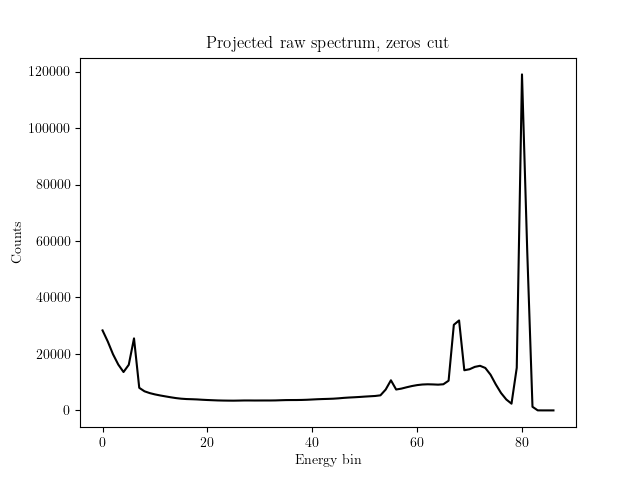

Text(0, 0.5, 'Counts')

In [5]:
%matplotlib notebook
%matplotlib notebook
# Cut out zeros from raw data

# Threshold, ignore counts before this bin
thres = 7 

# Determine indices of zeros in the array, there should be no nonzero counts after the first bin containing zero
# Returns a tuple where the first element is an array of indices
lst = np.where(raw_py==0)

# Cut out threshold area as well as all trailing zeros
raw_bay = raw_py[thres:lst[0][0]]
energy = Eg[thres:lst[0][0]]

plt.plot(raw_bay, color = 'black')
plt.title("Projected raw spectrum, zeros cut")
plt.xlabel("Energy bin")
plt.ylabel("Counts")

<IPython.core.display.Javascript object>


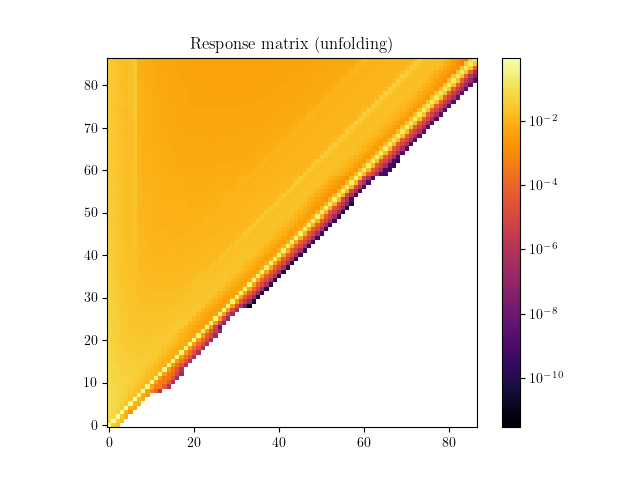

In [6]:
%matplotlib notebook
%matplotlib notebook

import matplotlib as mpl

# Response for use in fully bayesian unfolding
fwhm_abs = 30.0
folderpath = "ompy/OCL_response_functions/oscar2017_scale1.15"
response = om.Response(folderpath)

R_bay, R_tab_bay = response.interpolate(energy, fwhm_abs=fwhm_abs, return_table=True)
# For unfolding, use a lower resolution fwhm
R_bay_unf, R_tab_bay_unf = response.interpolate(energy, fwhm_abs=fwhm_abs/10, return_table=True)

#Scaling the response with efficiency: 

#Efficency is normalized to 1 for energy 1332 keV, but in this thesis the actual total efficency was calculated
#as 0.5, see chapter 5 in thesis for explanation: 
eff =0.5*R_tab_bay["eff_tot"].values

#The scale of the full energy peak 
pFE = R_tab_bay['pFE'].values

resp = R_bay.values*eff[:,np.newaxis]

# Normalizing the rows of the response
sum_of_rows = resp.sum(axis=1)
normalized_array = resp / sum_of_rows[:, np.newaxis]
resp = normalized_array

plt.figure()
plt.imshow(resp,origin = 'lower',norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('inferno'))

plt.colorbar()
plt.title("Response matrix (unfolding)")
plt.show()



<IPython.core.display.Javascript object>


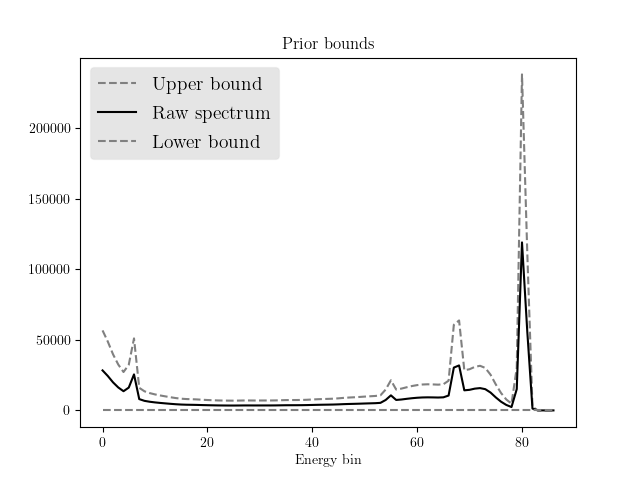

In [149]:
# Priors
%matplotlib notebook
%matplotlib notebook

# Defining lower and upper prior bounds
prior_l = np.zeros(len(raw_bay))
# prior_l = -1000*np.ones(len(raw_bay))
# prior_u = raw_bay/(eff*pFE) #Scaling the upper bounds with the efficiency and scale of full energy peak
# prior_l = raw_bay - 10000
# prior_u = raw_bay*10
prior_u = raw_bay*2
# prior_u = 1000*np.ones(len(raw_bay))
#Adding a constant to the bins containing the $1779$ keV energy peak
#prior_u[81] += 30000  
# prior_u[82] += 250000
# prior_u[85:] +=40000

# prior_u[79] += 30000
# prior_u[80] += 250000
# prior_u[81] += 50000


plt.plot(range(len(energy)), prior_u,ls='dashed', label = 'Upper bound', color = 'grey')
plt.plot(range(len(energy)), raw_bay, ls='-', label= 'Raw spectrum', color = 'black')
plt.plot(range(len(energy)), prior_l, ls='dashed', label = 'Lower bound', color = 'grey')


plt.title('Prior bounds')
plt.xlabel('Energy bin')
plt.legend(facecolor='grey', framealpha=0.2)
plt.show()   

In [8]:
# Initialize PyFBU
%matplotlib notebook
%matplotlib notebook

# Create PyFBU object
myfbu = fbu.PyFBU()

# Set the response
myfbu.response = resp

# Set data and priors 
myfbu.data = raw_bay
myfbu.prior = 'Uniform'
myfbu.upper = prior_u   
myfbu.lower = prior_l

In [9]:
# Set the number of tuning and sampling steps
myfbu.nTune = 1000
myfbu.nMCMC = 5000

# Run PyFBU
myfbu.run()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


None


Sequential sampling (2 chains in 1 job)
NUTS: [truth86, truth85, truth84, truth83, truth82, truth81, truth80, truth79, truth78, truth77, truth76, truth75, truth74, truth73, truth72, truth71, truth70, truth69, truth68, truth67, truth66, truth65, truth64, truth63, truth62, truth61, truth60, truth59, truth58, truth57, truth56, truth55, truth54, truth53, truth52, truth51, truth50, truth49, truth48, truth47, truth46, truth45, truth44, truth43, truth42, truth41, truth40, truth39, truth38, truth37, truth36, truth35, truth34, truth33, truth32, truth31, truth30, truth29, truth28, truth27, truth26, truth25, truth24, truth23, truth22, truth21, truth20, truth19, truth18, truth17, truth16, truth15, truth14, truth13, truth12, truth11, truth10, truth9, truth8, truth7, truth6, truth5, truth4, truth3, truth2, truth1, truth0]
100%|██████████| 6000/6000 [01:11<00:00, 83.49it/s]


Elapsed 0:02:44 (73.15 samples/second)
[1.13178568e-05 1.09399523e-05 1.08445523e-05 ... 7.49061106e-07
 2.20188359e-06 4.79109218e-06]


(array([-54354.65149779, -54355.70813176, -54354.1021857 , ...,
        -54350.88652209, -54353.11420408, -54353.77912499]),
 <MultiTrace: 2 chains, 5000 iterations, 174 variables>)

In [10]:
# Get all posterior samples for each bin, a list of lists
trace = myfbu.trace
print(len(trace), len(trace[0]))

87 10000


In [110]:
# Calculate means, medians and standard deviations for each posterior
means = np.mean(trace, axis = 1)
medians = np.median(trace, axis = 1)
sigmas = np.std(trace, axis = 1)


<IPython.core.display.Javascript object>


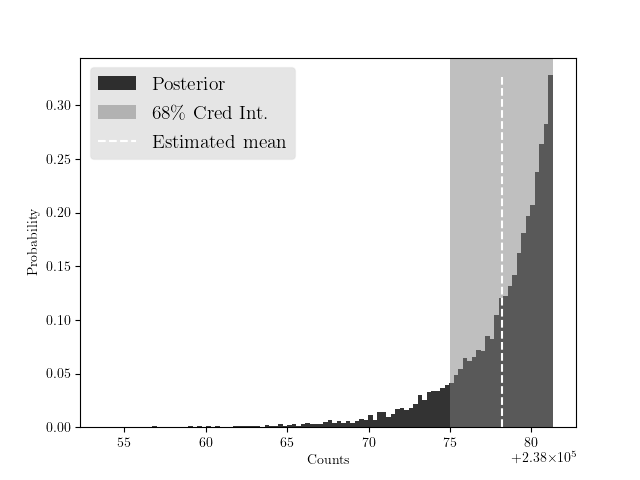

238078.17013146725


In [111]:
# %matplotlib notebook
# %matplotlib notebook
# # Figure showing the 68 % interval using the standard deviation of truthbin 82, corresponding to energy = 1778 keV
# # and with the estimated mean included

# fig, ax = plt.subplots()
# choice = 80
# n, bins,_ = ax.hist(trace[choice], label = 'Posterior',
#                     bins = 100, density = True, color = 'black', alpha = 0.8)
# height = np.max(n)
    
# ax.vlines(means[choice], 0, height, colors='white', ls = 'dashed', label='Estimated mean')
# ax.axvspan((means[choice] - sigmas[choice]), (means[choice] + sigmas[choice]), facecolor='grey', alpha=0.5, label=r'68\% Cred Int.')
    
    
# plt.xlabel('Counts')
# plt.ylabel('Probability')
# plt.legend(facecolor='grey', framealpha=0.2)

# plt.show()
# print(means[choice])

In [ ]:
# Estimating the median of the posteriors and the credible interval including the median
# import scipy as sp
# credible_level = 0.68
# degrees_freedom = len(trace) - 1
# median = np.zeros(len(trace))
# std_median= np.zeros(len(trace))
# cred_int_median = np.zeros((len(trace), 2))
# for i in range(len(trace)):
#     median[i] = np.median(trace[i])
#     std_median[i] = sp.stats.median_absolute_deviation(trace[i])
#     cred_int_median[i, :] = sp.stats.t.interval(credible_level, median[i], std_median[i])
    


print(median-medians)

In [140]:
# Estimating a HPD credible interval of the posteriors: 

hpd = np.zeros((len(trace),2))
for i in range(len(trace)):
    
    # CHANGED
    hpd[i:] = mc.stats.hpd(trace[i], alpha=1 - 0.68)

mean_inter = np.zeros(len(hpd))
for i in range(len(hpd)):
    mean_inter[i] =(hpd[i, 0]+hpd[i, 1])/2

<IPython.core.display.Javascript object>


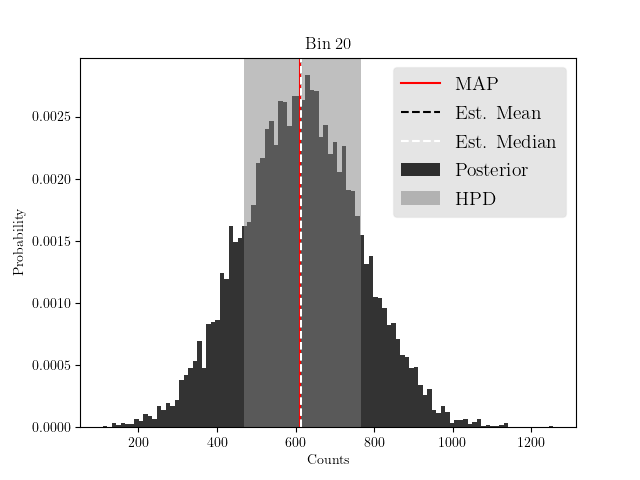

<IPython.core.display.Javascript object>


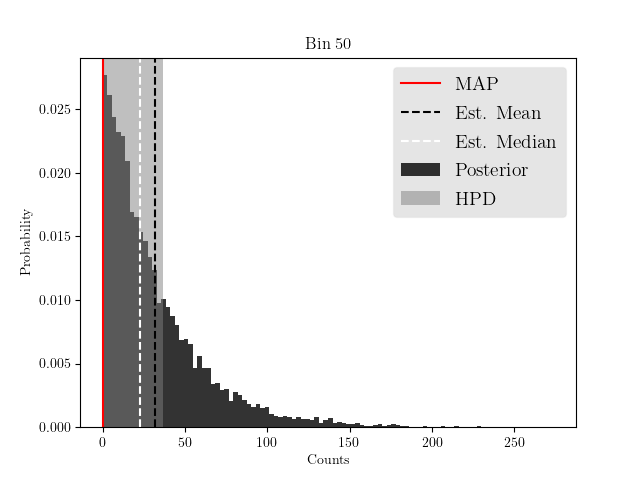

<IPython.core.display.Javascript object>


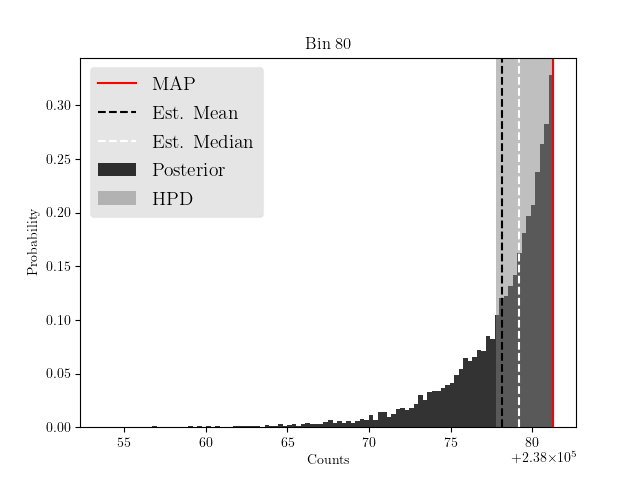

In [148]:
%matplotlib notebook
%matplotlib notebook

# Take a look at the situation for 3 bins
bin_numbers = [20, 50, 80]

for i in range(len(bin_numbers)):
    plt.figure()
    # Plot a histogram of the posterior
    n, bins,_ = plt.hist(trace[bin_numbers[i]], label = 'Posterior',
                        bins = 100, density = True, color = 'black', alpha = 0.8)

    # Plot lines at the positions of the mean, median and MAP estimates
    plt.axvline(x=MAP[bin_numbers[i]], color = 'red', ls = '-', label = 'MAP')
    plt.axvline(x=means[bin_numbers[i]], color = 'black', alpha = 1, ls = '--', label = 'Est. Mean')
    plt.axvline(x=medians[bin_numbers[i]], color = 'white', ls = '--', label = 'Est. Median')
    
    # Plot the HPD interval as a shaded area
    plt.axvspan(hpd[bin_numbers[i]][0], hpd[bin_numbers[i]][1], facecolor='grey', alpha=0.5, label=r'HPD')

    plt.title('Bin {}'.format(bin_numbers[i]))
    plt.xlabel('Counts')
    plt.ylabel('Probability')
    plt.legend(facecolor='grey', framealpha=0.2)
    plt.show()


In [23]:
# Calculating the MAP
myfbu.mode = True
myfbu.run()

None


logp = -54,714, ||grad|| = 0.15816: 100%|██████████| 127/127 [00:00<00:00, 518.00it/s] 


{'truth0_interval__': array(-3.58493248), 'truth1_interval__': array(-3.22538271), 'truth2_interval__': array(-2.82103508), 'truth3_interval__': array(-2.80228114), 'truth4_interval__': array(-2.97536095), 'truth5_interval__': array(-2.67548563), 'truth6_interval__': array(-1.70952447), 'truth7_interval__': array(-2.47785336), 'truth8_interval__': array(-2.66188853), 'truth9_interval__': array(-2.51266248), 'truth10_interval__': array(-2.50474759), 'truth11_interval__': array(-2.49792201), 'truth12_interval__': array(-2.54219499), 'truth13_interval__': array(-2.63011418), 'truth14_interval__': array(-2.71916765), 'truth15_interval__': array(-2.77450323), 'truth16_interval__': array(-2.64696649), 'truth17_interval__': array(-2.46441838), 'truth18_interval__': array(-2.34514764), 'truth19_interval__': array(-2.34384143), 'truth20_interval__': array(-2.40153539), 'truth21_interval__': array(-2.49767589), 'truth22_interval__': array(-2.61936068), 'truth23_interval__': array(-2.63607156), '

In [29]:
# Convert MAP dict to numpy array
MAP = np.fromiter(myfbu.MAP.values(), dtype=float)
# The second half of the original MAP contains the values we want
MAP = MAP[int(len(MAP)/2):]
print(len(MAP))

87


<IPython.core.display.Javascript object>


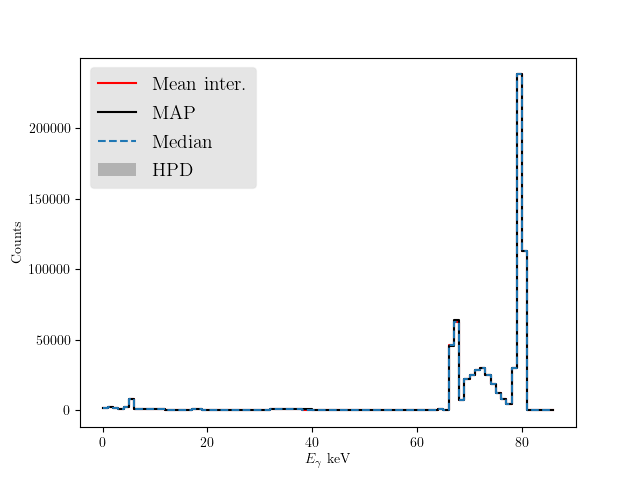

In [142]:
%matplotlib notebook
%matplotlib notebook

# Display entire spectrum uusing the estimates for each bin

# inds = np.random.randint(len(trace[0]), size=500)
# for ind in inds:
#     sample = np.zeros(len(trace))
#     for i in range(len(trace)):
#         sample[i] = trace[i][ind]
#     plt.step(range(len(energy)),sample, "C9", ls='-', alpha=0.2)

plt.step(range(len(energy)), mean_inter, color='red', alpha = 1, ls='-', label = r'Mean inter.')
plt.fill_between(x = range(len(energy)), y1 = hpd[:,0], y2 = hpd[:,1], step = 'pre', facecolor='grey', alpha=0.5, label =r'HPD')

plt.step(range(len(energy)), MAP, color = 'black', ls='-',alpha = 1, label = 'MAP')
plt.step(range(len(energy)), medians, ls='--', alpha = 1, label = 'Median')

# For prior_u scaled with efficiency
# plt.ylim(1E-5, 2E6)

# For prior_u = 2*raw
# plt.ylim(1E-7, 2E6)


# plt.yscale('log')
plt.ylabel('Counts')
plt.xlabel('$E_\gamma$ keV')
plt.legend()

import matplotlib.lines as mlines

# Add a 'samples' entry to the legend
# handles, labels = plt.gca().get_legend_handles_labels() # get existing handles and labels
# patch = mlines.Line2D([0],[0], color='C9', label='Sample') # create a patch with no color

# handles.append(patch) 
# labels.append("Samples")

# # Add vertical lines, showing the chosen bins
# for i in bin_numbers:
#     line = plt.axvline(x=i, color = 'red', ls = 'dashed', label = 'Chosen bin')
#     handles.append(line)
# labels.append('Chosen bins')
# plt.legend(handles, labels) # apply new handles and labels to plot
plt.legend(facecolor='grey', framealpha=0.2)

# plt.savefig("figures/logplot-1st-state.png")




plt.show()

<IPython.core.display.Javascript object>


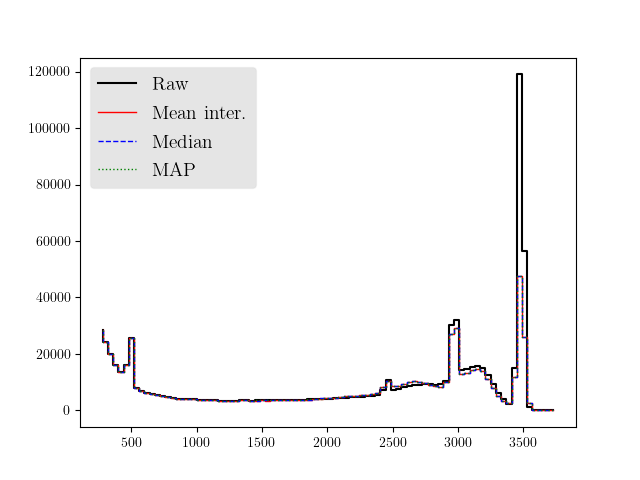

Mean absolute errors:
Mean interval            Median                   MAP
1594.8201348948644       1594.6512231873414       1590.183734241643


In [143]:
%matplotlib notebook
%matplotlib notebook
# Compare the folded estimates with the raw spectrum
plt.step(energy, raw_bay, label='Raw', color = 'black')
plt.step(energy, mean_inter@resp, alpha = 1, color = 'red', ls='-', linewidth = 1, label = r'Mean inter.')
plt.step(energy, medians@resp, ls='--', alpha = 1, color = 'blue', linewidth = 1, label = 'Median')
plt.step(energy, MAP@resp, ls='dotted', alpha = 1, color = 'green', linewidth = 1, label = 'MAP')

# plt.yscale('log')

plt.legend(facecolor='grey', framealpha=0.2)
plt.show()

print('Mean absolute errors:')
print('Mean interval            Median                   MAP\n{}       {}       {}'.format(\
    np.mean(np.abs(raw_bay - mean_inter@resp)), np.mean(np.abs(raw_bay - median@resp)), np.mean(np.abs(raw_bay - MAP@resp))))    
    
